In [0]:
!pip install tweet-preprocessor
import pandas as pd
import numpy as np
import scipy as sp
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from copy import deepcopy
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.stem import PorterStemmer 

import preprocessor as p

  Created wheel for tweet-preprocessor: filename=tweet_preprocessor-0.5.0-cp36-none-any.whl size=7947 sha256=9be9baa4fdb741d5394a50a2cf30393f5fa4a2b89282bff6cc675880a5b5083a
  Stored in directory: /root/.cache/pip/wheels/1b/27/cc/49938e98a2470802ebdefae9d2b3f524768e970c1ebbe2dc4a
Successfully built tweet-preprocessor
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/WebProject/labeledTrainData.csv", delimiter="\t",names=["tweet", "label", "labelValue"])

In [0]:
data["label"].replace({"spam": "neutral", "normal": "neutral"}, inplace=True)
data["label"].replace({"neutral":1, "abusive": 2,"hateful":3}, inplace=True)

In [0]:
def preprocess_tweet(tweet):

    # 1. Remove URLs, emojis, mentions, smileys using tweet-preprocessor library
    # should not remove hashtags as hashtags contains important tweet content.
    
    #p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION,p.OPT.RESERVED,	p.OPT.SMILEY,p.OPT.NUMBER)
    clean = p.clean(tweet)
    # 2. Remove HTML tags using Beautiful soup library
    no_tag = BeautifulSoup(clean).get_text()

    # 3. Expanding hashtags.
    
    #tweets_expanded = expand_hashtags(no_tag)

    # 4. Remove non letter char using re
    letters_only = re.sub("[^a-zA-Z]"," ", no_tag)
    #letters_only = re.sub("[^a-zA-Z]"," ", tweets_expanded)
    
    # 5. Convert to lower case
    lower_case = letters_only.lower()
    words = lower_case.split()

    new_words = []
    # ps = PorterStemmer() 
    # for w in words:
    #     new_words.append(ps.stem(w))
    for w in words:
        new_words.append(w)
    # print(new_words[0:4])
    # 5. Remove stop words
    # stops = set(stopwords.words("english")) 
    # final_words = [w for w in new_words if not w in stops]
    final_words = new_words

    return(" ".join( final_words ))

In [0]:
num_tweets = data["tweet"].size
for i in range(num_tweets):
    data["tweet"][i] = preprocess_tweet(data["tweet"][i])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
hateful = data["label"]==3
hateful = data[hateful]
hateful = hateful.sample(frac=1)
hateful = hateful.reset_index(drop=True)
hateful = hateful[:4333]
hateful['hateful'] = 1
hateful['abusive'] = 0
hateful['neutral'] = 0

In [0]:
abusive = data["label"]==2
abusive = data[abusive]
abusive = abusive.sample(frac=1)
abusive = abusive.reset_index(drop=True)
abusive = abusive[:4333]
abusive['hateful'] = 0
abusive['abusive'] = 1
abusive['neutral'] = 0

In [0]:
neutral = data["label"]==1
neutral = data[neutral]
neutral = neutral.sample(frac=1)
neutral = neutral.reset_index(drop=True)
neutral = neutral[:4334]
neutral['hateful'] = 0
neutral['abusive'] = 0
neutral['neutral'] = 1

In [0]:
union = pd.concat([hateful, abusive,neutral])

In [0]:
union = union.sample(frac=1)
union = union.reset_index(drop=True)

In [0]:
train = union[:10000]
validation = union[10000:11000]
test = union[11000:13000]

In [0]:
%matplotlib inline

In [0]:
!pip install transformers

import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [0]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)

In [0]:
max_seq = 100
target_columns = ["hateful", "abusive", "neutral"]

In [0]:
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.tweet.values
    ]


def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])


def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)


def targets_to_tensor(df):
    return torch.tensor(df[target_columns].values, dtype=torch.float32)

In [0]:
train_indices = tokenize_and_pad_text(train, max_seq)
val_indices = tokenize_and_pad_text(validation, max_seq)
test_indices = tokenize_and_pad_text(test, max_seq)

In [0]:
with torch.no_grad():
  for i in range(10):
    if i == 0:
      x_train = bert_model(train_indices[:1000])[0]
      x_val = bert_model(val_indices[:1000])[0]
      x_test = bert_model(test_indices[:1000])[0]
    else:
      x_train = torch.cat((x_train,bert_model(train_indices[i*1000:(i+1)*1000])[0]),dim=0)
      x_val = torch.cat((x_val,bert_model(val_indices[i*1000:(i+1)*1000])[0]),dim=0)
      x_test = torch.cat((x_test,bert_model(test_indices[i*1000:(i+1)*1000])[0]),dim=0)

In [0]:
y_train = targets_to_tensor(train)
y_val = targets_to_tensor(validation)
y_test = targets_to_tensor(test)

In [0]:
torch.save(x_train, 'x_train.pt')
torch.save(x_val, 'x_val.pt')
torch.save(x_test, 'x_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_val, 'y_val.pt')
torch.save(y_test, 'y_test.pt')

In [0]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()

        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        if self.static:
            x = Variable(x)

        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [0]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5
static = True

In [0]:
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
)

In [0]:
n_epochs = 10
batch_size = 10
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [0]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [0]:
train_losses, val_losses = [], []

for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0

    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time

    model.eval() # disable dropout for deterministic output
    with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)

    print(
        "Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."
        % (epoch + 1, train_losses[-1], val_losses[-1], elapsed)
    )

Epoch 1 Train loss: 0.54. Validation loss: 0.42. Elapsed time: 49.22s.
Epoch 2 Train loss: 0.48. Validation loss: 0.40. Elapsed time: 48.55s.
Epoch 3 Train loss: 0.45. Validation loss: 0.39. Elapsed time: 48.57s.
Epoch 4 Train loss: 0.44. Validation loss: 0.39. Elapsed time: 48.65s.
Epoch 5 Train loss: 0.43. Validation loss: 0.38. Elapsed time: 48.58s.
Epoch 6 Train loss: 0.42. Validation loss: 0.39. Elapsed time: 48.42s.
Epoch 7 Train loss: 0.42. Validation loss: 0.40. Elapsed time: 50.66s.
Epoch 8 Train loss: 0.42. Validation loss: 0.40. Elapsed time: 48.63s.
Epoch 9 Train loss: 0.41. Validation loss: 0.39. Elapsed time: 48.44s.
Epoch 10 Train loss: 0.40. Validation loss: 0.39. Elapsed time: 48.36s.


Text(0.5, 1.0, 'Losses')

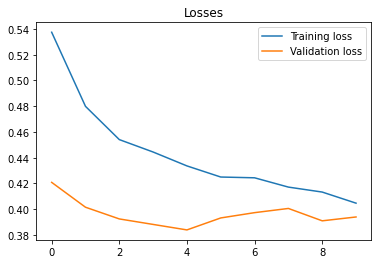

In [0]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Losses")

In [0]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        print(y_pred)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

In [0]:
auc_scores = roc_auc_score(y_test_np, y_preds_np, average=None)
df_accuracy = pd.DataFrame({"label": target_columns, "auc": auc_scores})
df_accuracy.sort_values('auc')[::-1]

,label,auc
2,neutral,0.936644
1,abusive,0.902222
0,hateful,0.849197
